In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

E:\anaconda3\envs\jcopml2\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Import Data

In [2]:
df = pd.read_csv("data/iris.csv", index_col="Id")
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
df.Species.value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64

# Visualize Data

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

E:\anaconda3\envs\jcopml2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
E:\anaconda3\envs\jcopml2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PetalLengthCm', ylabel='PetalWidthCm'>

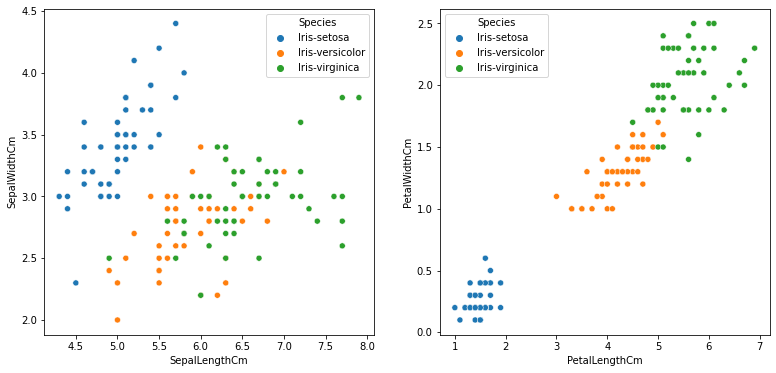

In [5]:
plt.figure(figsize=(13, 6))
plt.subplot(121)
sns.scatterplot("SepalLengthCm", "SepalWidthCm", "Species", data=df)
plt.subplot(122)
sns.scatterplot("PetalLengthCm", "PetalWidthCm", "Species", data=df)

# Dataset Splitting

In [6]:
X = df.drop(columns="Species")
y = df.Species

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

# Training

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

### One vs Rest / One vs All

In [8]:
gsp.logreg_params

{'algo__fit_intercept': [True, False],
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [9]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(multi_class="ovr", solver='lbfgs', n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.logreg_params, cv=4, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 4 folds for each of 14 candidates, totalling 56 fits
{'algo__C': 10.0, 'algo__fit_intercept': True}
0.9583333333333334 0.9583333333333334 0.9666666666666667


### Multinomial 

In [11]:
gsp.logreg_poly_params

{'prep__numeric__poly__degree': [1, 2, 3],
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__fit_intercept': [True, False],
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [10]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(multi_class="multinomial", solver='lbfgs', n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.logreg_params, cv=4, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 4 folds for each of 14 candidates, totalling 56 fits
{'algo__C': 10.0, 'algo__fit_intercept': True}
0.975 0.9666666666666667 1.0
